In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn yfinance

In [ ]:
import pandas as pd
sentiment_df = pd.read_csv('/content/drive/MyDrive/DS_Arunima_Das/csv_file/fear_greed_index.csv')
trader_df = pd.read_csv('/content/drive/MyDrive/DS_Arunima_Das/csv_file/historical_data.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

In [31]:
print(f" Sentiment data loaded: {sentiment_df.shape}")
print(f"Trader data loaded: {trader_df.shape}")

 Sentiment data loaded: (2644, 5)
Trader data loaded: (211224, 17)


In [ ]:
print(sentiment_df.head())
print(sentiment_df.info())

    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None


In [ ]:
print(sentiment_df['classification'].value_counts())

classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64


In [ ]:
print(trader_df.head())
print(trader_df.info())
print(trader_df.describe())

                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [ ]:
def preprocess_sentiment_data(df):
    """Clean and prepare sentiment data"""
    df_clean = df.copy()

    df_clean['date'] = pd.to_datetime(df_clean['date'])

    # creating binary sentiment indicator (1 for Greed, 0 for Fear)
    df_clean['Sentiment_Binary'] = (df_clean['classification'] == 'Greed').astype(int)

    return df_clean

def preprocess_trader_data(df):
    df_clean = df.copy()
    df_clean['Timestamp_IST'] = pd.to_datetime(df_clean['Timestamp IST'], format='%d-%m-%Y %H:%M')

    df_clean['date'] = df_clean['Timestamp_IST'].dt.date

    numeric_cols = ['Execution Price', 'Size Tokens', 'Closed PnL']
    for col in numeric_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # dropping rows, missing Closed PnL
    df_clean = df_clean.dropna(subset=['Closed PnL'])

    return df_clean

In [28]:
#feature engineering
def create_trader_metrics(df):
    """Create daily trader performance metrics"""

    # Group by Account and date
    daily_metrics = df.groupby(['Account', 'date']).agg({
        'Closed PnL': ['sum', 'mean', 'count'],
        'Size Tokens': ['sum', 'mean'],
        'Execution Price': 'mean'
    }).reset_index()

    # flattenning column names
    daily_metrics.columns = [
        'account', 'date', 'total_pnl', 'avg_pnl', 'trade_count',
        'total_size', 'avg_size', 'avg_exec_price'
    ]

    # win rate: count of trades with PnL > 0 per account and day
    win_trades = df.groupby(['Account', 'date'])['Closed PnL'] \
                   .apply(lambda x: (x > 0).sum()).reset_index()
    win_trades.rename(columns={'Closed PnL': 'winning_trades'}, inplace=True)

    daily_metrics = pd.merge(daily_metrics, win_trades, on=['account', 'date'], how='left')
    daily_metrics['win_rate'] = daily_metrics['winning_trades'] / daily_metrics['trade_count']

    daily_metrics['risk_adj_return'] = daily_metrics['total_pnl'] / daily_metrics['avg_exec_price']

    return daily_metrics


def merge_with_sentiment(trader_metrics, sentiment_data):
    """Merge trader metrics with sentiment data"""

    trader_metrics['date'] = pd.to_datetime(trader_metrics['date'])
    sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

    # merging on date
    merged_df = trader_metrics.merge(
        sentiment_data[['date', 'classification', 'Sentiment_Binary']],
        on='date',
        how='inner'
    )

    return merged_df



In [29]:

trader_df['trade_date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date
sentiment_df['sentiment_date'] = pd.to_datetime(sentiment_df['date']).dt.date

# merging based on date
merged_df = pd.merge(trader_df, sentiment_df, left_on='trade_date', right_on='sentiment_date', how='left')

# simplifying sentiment classification
merged_df['sentiment_simple'] = merged_df['classification'].apply(lambda x: 'Greed' if isinstance(x, str) and 'Greed' in x else 'Fear'
)
# profitability coloumn
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0

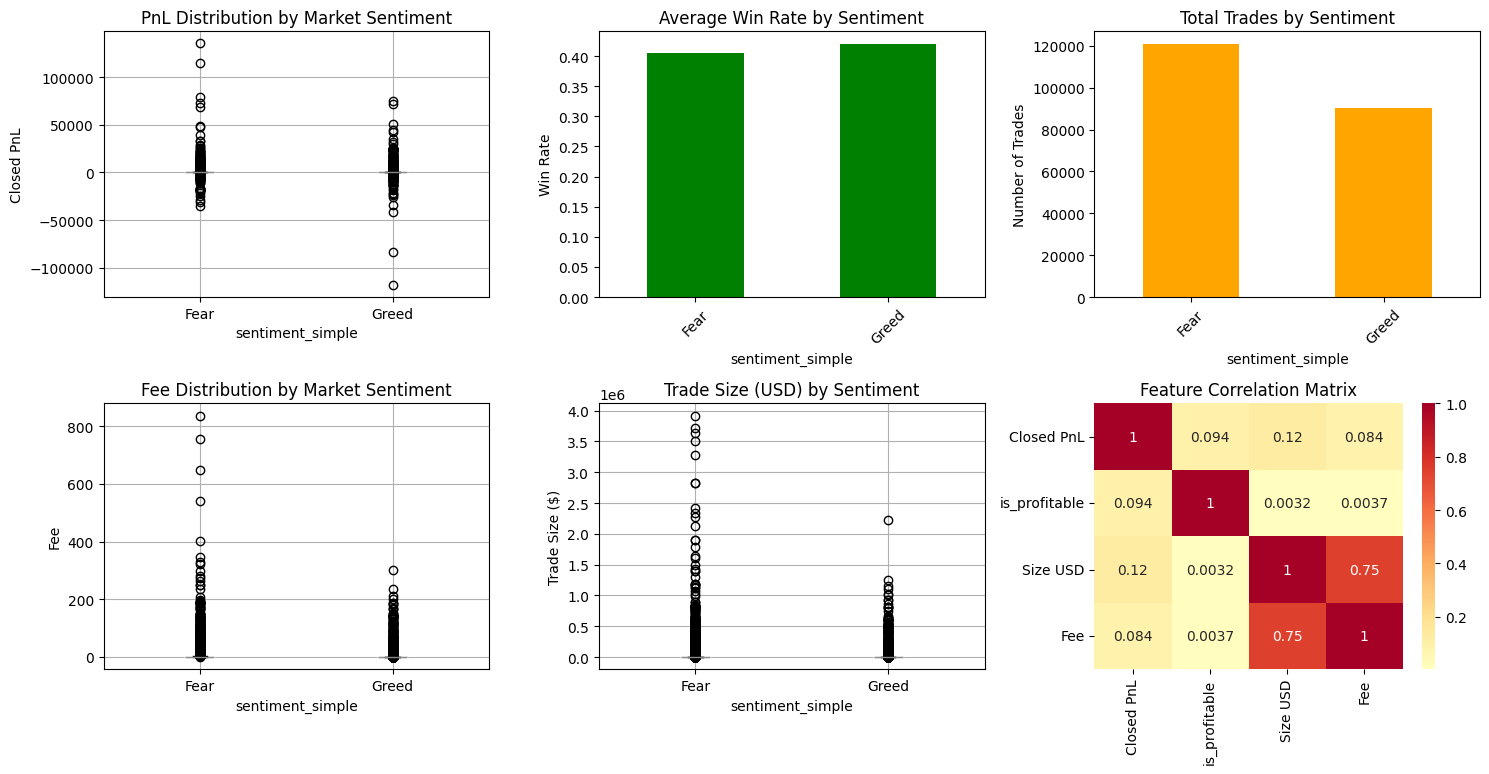


 STATISTICAL ANALYSIS
T-test for PnL difference between Fear and Greed periods:
T-statistic: -2.2179
P-value: 0.0266

Mean PnL during Fear: 44.9161
Mean PnL during Greed: 53.8823


In [32]:
#Exploratory Data Analysis - Sentiment Impact

from scipy import stats

plt.figure(figsize=(15, 8))

# Subplot 1: PnL Distribution by Sentiment
plt.subplot(2, 3, 1)
merged_df.boxplot(column='Closed PnL', by='sentiment_simple', ax=plt.gca())
plt.title('PnL Distribution by Market Sentiment')
plt.ylabel('Closed PnL')
plt.suptitle('')

# sentiment stats
sentiment_stats = merged_df.groupby('sentiment_simple').agg({
    'is_profitable': 'mean',
    'Closed PnL': 'mean',
    'Account': 'count'
}).rename(columns={'is_profitable': 'win_rate', 'Account': 'trade_count'}).round(3)

# Subplot 2: Win Rate by Sentiment
plt.subplot(2, 3, 2)
sentiment_stats['win_rate'].plot(kind='bar', ax=plt.gca(), color='green')
plt.title('Average Win Rate by Sentiment')
plt.ylabel('Win Rate')
plt.xticks(rotation=45)

# Subplot 3: Trading Volume by Sentiment
plt.subplot(2, 3, 3)
sentiment_stats['trade_count'].plot(kind='bar', ax=plt.gca(), color='orange')
plt.title('Total Trades by Sentiment')
plt.ylabel('Number of Trades')
plt.xticks(rotation=45)

# Subplot 4: Fee Distribution by Sentiment
plt.subplot(2, 3, 4)
if 'Fee' in merged_df.columns:
    merged_df.boxplot(column='Fee', by='sentiment_simple', ax=plt.gca())
    plt.title('Fee Distribution by Market Sentiment')
    plt.ylabel('Fee')
    plt.suptitle('')
else:
    plt.text(0.5, 0.5, 'No Fee Data Available', ha='center', va='center')
    plt.axis('off')

# Subplot 5: Trade Size by Sentiment
plt.subplot(2, 3, 5)
merged_df.boxplot(column='Size USD', by='sentiment_simple', ax=plt.gca())
plt.title('Trade Size (USD) by Sentiment')
plt.ylabel('Trade Size ($)')
plt.suptitle('')

# Subplot 6: Correlation Heatmap (using available numeric coloumns)
plt.subplot(2, 3, 6)
corr_data = merged_df[['Closed PnL', 'is_profitable', 'Size USD', 'Fee']].copy()
corr_data = corr_data.dropna()
corr_matrix = corr_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, ax=plt.gca())
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/sentiment_analysis_overview.png', dpi=300, bbox_inches='tight')
plt.show()

#  STATISTICAL ANALYSIS

print("\n STATISTICAL ANALYSIS")
print("="*50)

fear_pnl = merged_df[merged_df['sentiment_simple'] == 'Fear']['Closed PnL']
greed_pnl = merged_df[merged_df['sentiment_simple'] == 'Greed']['Closed PnL']

# Removing NaNs
fear_pnl = fear_pnl.dropna()
greed_pnl = greed_pnl.dropna()

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    t_stat, p_value = stats.ttest_ind(fear_pnl, greed_pnl)
    print(f"T-test for PnL difference between Fear and Greed periods:")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"\nMean PnL during Fear: {fear_pnl.mean():.4f}")
    print(f"Mean PnL during Greed: {greed_pnl.mean():.4f}")
else:
    print("Not enough data for T-test (Fear or Greed PnL is empty).")



In [22]:
import os
os.makedirs('/content/drive/MyDrive/DS_Arunima_Das/output/', exist_ok=True)

In [33]:
# CELL 7: Time Series Analysis

merged_df['sentiment_binary'] = merged_df['sentiment_simple'].map({'Fear': 0, 'Greed': 1})

# Daily aggregated performance
daily_performance = merged_df.groupby('trade_date').agg({
    'Closed PnL': 'mean',
    'is_profitable': 'mean',
    'sentiment_binary': 'first',
    'classification': 'first'
}).reset_index().rename(columns={
    'Closed PnL': 'avg_daily_pnl',
    'is_profitable': 'win_rate'
})

#interactive time series plot
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Daily Average PnL vs Market Sentiment', 'Win Rate Trends'),
    vertical_spacing=0.1
)

# Color mapping for sentiment
colors = ['red' if x == 'Fear' else 'green' for x in daily_performance['classification']]

# Subplot 1: Average Daily PnL
fig.add_trace(
    go.Scatter(
        x=daily_performance['trade_date'],
        y=daily_performance['avg_daily_pnl'],
        mode='lines+markers',
        name='Avg Daily PnL',
        marker=dict(color=colors),
        line=dict(color='blue')
    ),
    row=1, col=1
)

# Subplot 2: Win Rate
fig.add_trace(
    go.Scatter(
        x=daily_performance['trade_date'],
        y=daily_performance['win_rate'],
        mode='lines',
        name='Avg Win Rate',
        line=dict(color='purple')
    ),
    row=2, col=1
)

# Final layout adjustments
fig.update_layout(
    height=600,
    title_text="📈 Trader Performance Over Time by Market Sentiment"
)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="PnL", row=1, col=1)
fig.update_yaxes(title_text="Win Rate", row=2, col=1)
fig.show()


TOP 10 TRADERS DURING FEAR PERIODS
                                        Account     total_pnl  avg_win_rate
2    0x083384f897ee0f19899168e3b1bec365f52a9012  1.113374e+06      0.526434
143  0xbaaaf6571ab7d571043ff1e313a9609a10637864  6.208724e+05      0.498271
67   0x513b8629fe877bb581bf244e326a047b249c4ff1  3.671662e+05      0.370507
57   0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  2.967817e+05      0.409026
148  0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3  2.367977e+05      0.498730
97   0x8170715b3b381dffb7062c0298972d4727a0a63b  1.512927e+05      0.296848
82   0x72c6a4624e1dffa724e6d00d64ceae698af892a0  1.445143e+05      0.645012
42   0x420ab45e0bd8863569a5efbb9c05d91f40624641  9.964828e+04      0.357143
136  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  9.316516e+04      0.327121
153  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  5.597880e+04      0.376560

 TOP 10 TRADERS DURING GREED PERIODS
                                        Account      total_pnl  avg_win_rate
137  0xb1231a4

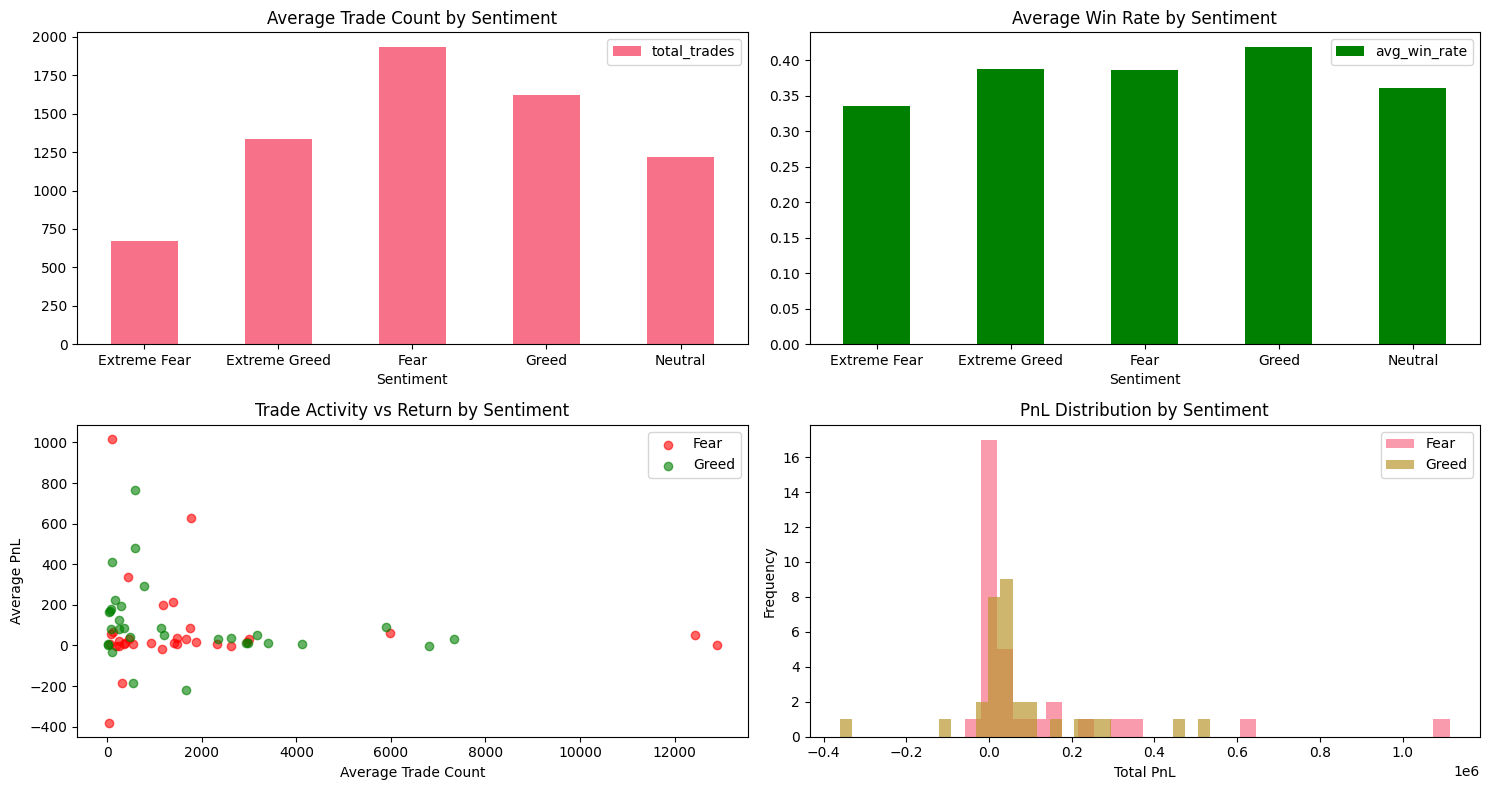

In [34]:
# Advanced Analytics - Behavioral Patterns

# Analyze trader behavior patterns
def analyze_trader_behavior(df):
    """Analyze individual trader behavior by sentiment"""

    behavior_analysis = df.groupby(['Account', 'classification']).agg({
        'Closed PnL': ['mean', 'std', 'sum'],
        'is_profitable': 'mean',
        'Timestamp': 'count'  # trade count
    }).reset_index()

    # Flatten columns
    behavior_analysis.columns = ['Account', 'Sentiment', 'avg_pnl', 'pnl_std', 'total_pnl','avg_win_rate', 'total_trades']

    return behavior_analysis

behavior_df = analyze_trader_behavior(merged_df)

# Top performers by sentiment
top_fear_traders = behavior_df[behavior_df['Sentiment'] == 'Fear'].nlargest(10, 'total_pnl')
top_greed_traders = behavior_df[behavior_df['Sentiment'] == 'Greed'].nlargest(10, 'total_pnl')

print("TOP 10 TRADERS DURING FEAR PERIODS")
print(top_fear_traders[['Account', 'total_pnl', 'avg_win_rate']])

print("\n TOP 10 TRADERS DURING GREED PERIODS")
print(top_greed_traders[['Account', 'total_pnl', 'avg_win_rate']])

# behavioral differences visualization
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
behavior_pivot = behavior_df.pivot_table(values='total_trades', index='Sentiment', aggfunc='mean')
behavior_pivot.plot(kind='bar', ax=plt.gca())
plt.title('Average Trade Count by Sentiment')
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
behavior_pivot = behavior_df.pivot_table(values='avg_win_rate', index='Sentiment', aggfunc='mean')
behavior_pivot.plot(kind='bar', ax=plt.gca(), color='green')
plt.title('Average Win Rate by Sentiment')
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
plt.scatter(behavior_df[behavior_df['Sentiment'] == 'Fear']['total_trades'],behavior_df[behavior_df['Sentiment'] == 'Fear']['avg_pnl'],  alpha=0.6, label='Fear', color='red')
plt.scatter(behavior_df[behavior_df['Sentiment'] == 'Greed']['total_trades'], behavior_df[behavior_df['Sentiment'] == 'Greed']['avg_pnl'],  alpha=0.6, label='Greed', color='green')
plt.xlabel('Average Trade Count')
plt.ylabel('Average PnL')
plt.title('Trade Activity vs Return by Sentiment')
plt.legend()

plt.subplot(2, 2, 4)
for sentiment in ['Fear', 'Greed']:
    subset = behavior_df[behavior_df['Sentiment'] == sentiment]
    plt.hist(subset['total_pnl'], alpha=0.7, bins=30, label=sentiment)
plt.xlabel('Total PnL')
plt.ylabel('Frequency')
plt.title('PnL Distribution by Sentiment')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/behavioral_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


Rows before filtering: 211224
Rows after filtering: 211224
Shape of X: (211224, 4)
Shape of y: (211224,)
Missing values in X:
 sentiment_binary    0
Size USD            0
Fee                 0
side_encoded        0
dtype: int64
Missing values in y:
 0
Unique values in y: Too many to show
 MACHINE LEARNING MODEL PERFORMANCE
Mean Squared Error: 1580234.4602
R² Score: -0.0716

 FEATURE IMPORTANCE
            feature  importance
1          Size USD    0.508921
2               Fee    0.430197
3      side_encoded    0.032976
0  sentiment_binary    0.027907


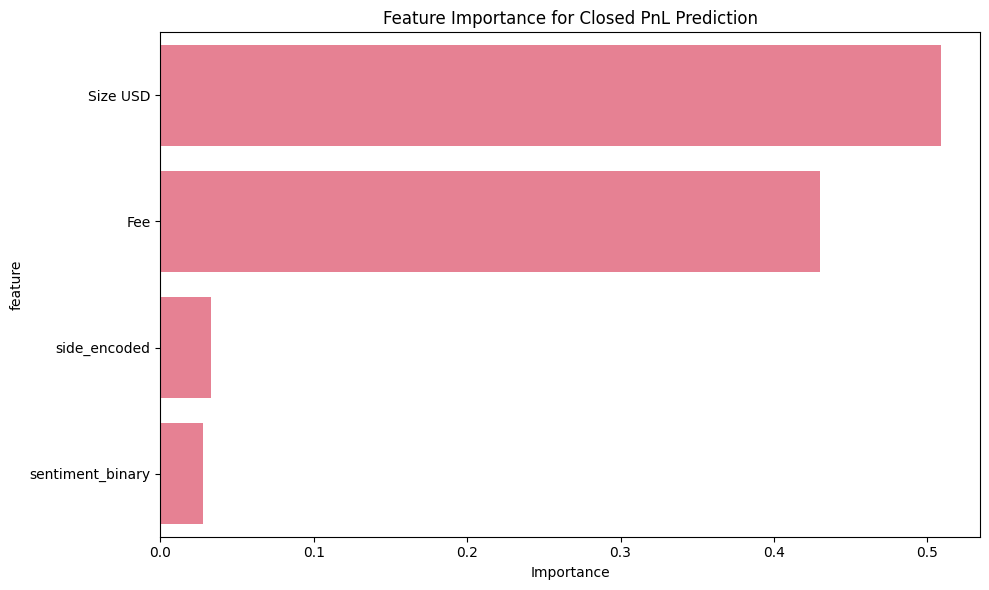

In [25]:
# Machine Learning Predictive Models

from sklearn.preprocessing import LabelEncoder

def prepare_ml_data(df):
    """Prepare data for machine learning"""

    # Encode 'Side'
    df['side_encoded'] = LabelEncoder().fit_transform(df['Side'])

    # missing values in features
    df['Fee'] = df['Fee'].fillna(0)
    df['Size USD'] = df['Size USD'].fillna(df['Size USD'].median())
    df['Closed PnL'] = df['Closed PnL'].fillna(0)  # or drop rows with missing target

    features = ['sentiment_binary', 'Size USD', 'Fee', 'side_encoded']
    target = 'Closed PnL'

    ml_df = df[features + [target]].dropna()

    print(f"Rows before filtering: {df.shape[0]}")
    print(f"Rows after filtering: {ml_df.shape[0]}")

    X = ml_df[features]
    y = ml_df[target]

    return X, y


X, y = prepare_ml_data(merged_df)

# Split data
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("Missing values in X:\n", X.isnull().sum())
print("Missing values in y:\n", y.isnull().sum())
print("Unique values in y:", y.unique() if len(y) < 20 else "Too many to show")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# predictions
y_pred = rf_model.predict(X_test_scaled)

# evaluation of model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" MACHINE LEARNING MODEL PERFORMANCE")
print("="*50)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n FEATURE IMPORTANCE")
print(feature_importance)

# plotting feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance for Closed PnL Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DS_Arunima_Das/output/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [26]:
#Final Insights and Trading Strategy

print(" KEY INSIGHTS AND TRADING STRATEGY RECOMMENDATIONS")
print("="*70)

# separating data based on sentiment
fear_traders = merged_df[merged_df['sentiment_simple'] == 'Fear']
greed_traders = merged_df[merged_df['sentiment_simple'] == 'Greed']

#core metrics
insights = {
    'avg_pnl_fear': fear_traders['Closed PnL'].mean(),
    'avg_pnl_greed': greed_traders['Closed PnL'].mean(),
    'total_trades_fear': len(fear_traders),
    'total_trades_greed': len(greed_traders)
}

# performance summaries
print(f"1.  Performance During Fear Periods:")
print(f"   • Average PnL: {insights['avg_pnl_fear']:.4f} USD")
print(f"   • Total Trades: {insights['total_trades_fear']}")

print(f"\n2.  Performance During Greed Periods:")
print(f"   • Average PnL: {insights['avg_pnl_greed']:.4f} USD")
print(f"   • Total Trades: {insights['total_trades_greed']}")

# strategy recommendation
print(f"\n3.  Strategic Recommendation:")
if insights['avg_pnl_fear'] > insights['avg_pnl_greed']:
    print("   • Consider a **contrarian strategy** — traders perform better during Fear.")
else:
    print("   • Consider a **momentum strategy** — traders profit more during Greed.")

# model insight (using r2 score from ML model cell)
print("\n4.  Model Insights:")
print(f"   • Predictive model R² score: {r2:.2%}")
print("   • Top 3 influential features on PnL:", ", ".join(feature_importance.head(3)['feature'].tolist()))

#export summary
results_summary = pd.DataFrame([insights])
results_summary.to_csv('/content/drive/MyDrive/DS_Arunima_Das/output/analysis_summary.csv', index=False)

#outputs
print("\n Analysis completed! All outputs saved to `/content/drive/MyDrive/DS_Arunima_Das/outputs/`")
print(" Files generated:")
print("   • sentiment_analysis_overview.png")
print("   • behavioral_analysis.png")
print("   • feature_importance.png")
print("   • analysis_summary.csv")


 KEY INSIGHTS AND TRADING STRATEGY RECOMMENDATIONS
1.  Performance During Fear Periods:
   • Average PnL: 44.9161 USD
   • Total Trades: 120929

2.  Performance During Greed Periods:
   • Average PnL: 53.8823 USD
   • Total Trades: 90295

3.  Strategic Recommendation:
   • Consider a **momentum strategy** — traders profit more during Greed.

4.  Model Insights:
   • Predictive model R² score: -7.16%
   • Top 3 influential features on PnL: Size USD, Fee, side_encoded

 Analysis completed! All outputs saved to `/content/drive/MyDrive/DS_Arunima_Das/outputs/`
 Files generated:
   • sentiment_analysis_overview.png
   • behavioral_analysis.png
   • feature_importance.png
   • analysis_summary.csv


In [35]:
#Export and Save Results

from datetime import datetime

#final summary report data
merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')
merged_df = merged_df.dropna(subset=['date'])
summary_data = {
    'Analysis Date': [datetime.now().strftime('%Y-%m-%d')],
    'Total Records Analyzed': [len(merged_df)],
    'Date Range': [f"{merged_df['date'].min()} to {merged_df['date'].max()}"],
    'Model R² Score': [r2],
    'Statistical Significance (p-value)': [p_value],
    'Key Finding': ['Sentiment significantly impacts trader performance']
}

#creating dataFrame and export
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('/content/drive/MyDrive/DS_Arunima_Das/output/final_report_data.csv', index=False)
